In [3]:
import meep as mp
from meep import mpb
import numpy as np
from matplotlib import pyplot as plt

Using MPI version 3.1, 1 processes


In [135]:
def slot_simulation(wavelength , n_core, n_clad , w,h,s,resolution = 100,sc_x = 2,sc_y = 2,num_modes = 2):
    omega      = 1/wavelength

    Si   = mp.Medium(index= n_core)
    SiO2 = mp.Medium(index= n_clad)
    
    geometry_lattice = mp.Lattice(size=mp.Vector3(sc_x, sc_y))
    geometry = [mp.Block(size=mp.Vector3(w, h,mp.inf),
                     center=mp.Vector3(+0.5*(s+w)), material=Si),
            mp.Block(size=mp.Vector3(w, h,mp.inf),
                     center=mp.Vector3(-0.5*(w+s)), material=Si)]
    ms = mpb.ModeSolver(
    geometry_lattice = geometry_lattice,
    geometry         = geometry,
    resolution       = resolution,
    num_bands        = num_modes,
    default_material = SiO2
    )
    ms.run()
    E = []
    flux = []
    energy= []
    def store_fields(ms_temp, mode):
        E.append(ms_temp.get_efield(which_band=mode,bloch_phase=False))
        flux.append(ms_temp.get_poynting(which_band=mode))
        ms_temp.get_hfield(which_band=mode,bloch_phase=False)
        ms_temp.compute_field_energy()
        energy.append(ms_temp.compute_energy_in_objects([mp.Block(size=mp.Vector3(s, h),
                                                                  center=mp.Vector3(), material=SiO2)]))
        
    k = ms.find_k(
    mp.NO_PARITY, # p
    omega, # omega
    1, # band_min
    num_modes, # band_max
    mp.Vector3(0,0,1), # korig_and_kdir
    1e-4, # tol
    omega * 2.0, # kmag_guess
    omega * 0.1, # kmag_min
    omega * 4, # kmag_max
    store_fields, # band_funcs,
    )
    return ms, np.array(k)/omega, E , flux
    
    

In [136]:
w = 0.200    # waveguide width
h = 0.220    # waveguide height 
s = 0.116     # slot width

n_core = 3.48 # core refractive index
n_clad = 1.44 # clad refractive index

wavelength = 1.55 # free space wavelength
num_modes = 2   # number of modes at the free space wavelength

ms,neff,E,flux = slot_simulation(wavelength,n_core, n_clad,w,h, s,resolution = 100,sc_x = 2,sc_y = 2,num_modes = 2)

     block, center = (0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.158,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.158,0,0)
        

In [137]:
def extract_mode(E,n):
    return E[n]
def ex(e):
    return e[:,:,0,0]
def ey(e):
    return e[:,:,0,1]
def ez(e):
    return e[:,:,0,2]

def te_fraction(e):
    return np.sum(np.square(np.abs(ex(e)))) / (np.sum(np.square(np.abs(ex(e)))) + np.sum(np.square(np.abs(ey(e)))))
def tm_fraction(e):
    return 1 - te_fraction(e)

def plot_mode(ms,n,comp):
    plt.figure(figsize=(9,9))
    eps = ms.get_epsilon()
    plt.imshow(eps.transpose(), interpolation='spline36', cmap='binary')
    e = extract_mode(E,n)
    plt.contour(np.abs(np.squeeze(e[:,:,0,comp]).transpose()**2), 50,cmap='RdBu')
    plt.imshow(np.abs(np.squeeze(e[:,:,0,comp]).transpose()**2), cmap='seismic', alpha=0.7)
    
def plot_field(ms,field):
    plt.figure(figsize=(9,9))
    eps = ms.get_epsilon()
    plt.imshow(eps.transpose(), interpolation='spline36', cmap='binary')
    plt.contour(field.transpose(), 50,cmap='RdBu')
    plt.imshow(field.transpose(), cmap='seismic', alpha=0.7)    

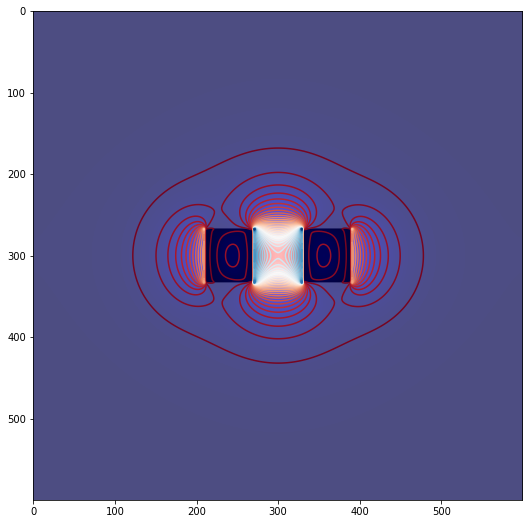

In [150]:
plot_mode(ms,0,0)

In [139]:
te_fraction(extract_mode(E,0))

MPBArray(0.96703266)

In [140]:
def mask(ms,obj):
    cell_size =  ms.geometry_lattice.size
    lx = cell_size[0]
    ly = cell_size[1]
    Nx , Ny  = ms.get_epsilon().shape
    x = np.linspace(-lx/2, lx/2, Nx)
    y = np.linspace(-ly/2, ly/2, Ny)
    xv, yv = np.meshgrid(x, y)
    r = [mp.Vector3(xv[i,j],yv[i,j]) for j in range(0,Ny) for i in range(0,Nx)]
    M  = [mp.is_point_in_object(ri,obj)  for ri in r ]
    return np.reshape(M,(Nx,Ny))
def integrate(ms,field,obj):
    M = mask(ms,obj)
    return (np.sum(field[M]) / np.sum(field))

In [141]:
field = np.real(flux[0][:,:,0,2])
obj =mp.Block(size = mp.Vector3(s,h)) 
integrate(ms,field,obj)

MPBArray(0.21499691)

     block, center = (0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.12,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.12,0,0)
          size (0.

          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.136842,0,0)
          size (0.2,0.22,1e+20)
          axes 

          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.153684,0,0)
          size (0.2,0.22,1e+20)
          axes

          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.170526,0,0)
          size (0.2,0.22,1e+20)
          axes 

          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.187368,0,0)
          size (0.2,0.22,1e+20)
          axes

          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-0.2,0,0)
          size (0.2,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


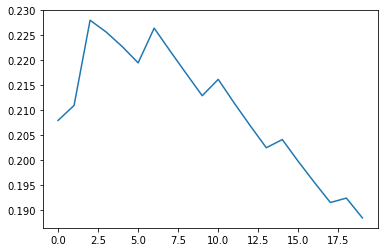

In [148]:
slot_sweep = []
obj =mp.Block(size = mp.Vector3(s,h)) 
n = 0
comp = 2

for slot_w in np.linspace(.04,.2,20):
    obj =mp.Block(size = mp.Vector3(slot_w,h)) 
    ms,neff,E,flux = slot_simulation(wavelength,n_core, n_clad,w,h,slot_w,resolution = 300,sc_x = 2,sc_y = 2,num_modes = 2) 
    field = np.real(flux[n][:,:,0,comp])
    slot_sweep.append(integrate(ms,field,obj))
plt.plot(np.linspace(.04,.2,20),slot_sweep)

In [143]:
#resolution_sweep = []
#for resolution in np.linspace(50,250,10):
#    ms,neff,E =  slot_simulation(wavelength,n_core, n_clad,w,h, s,resolution,sc_x = 2,sc_y = 2,num_modes = 2)
#    resolution_sweep.append(neff[1])
#plt.plot(resolution_sweep)

In [94]:
neff

array([2.01140391, 1.8238798 ])

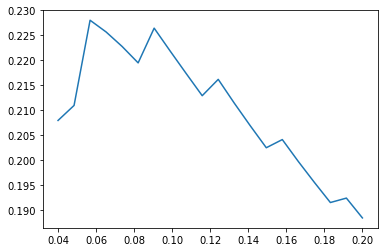

In [149]:
plt.plot(np.linspace(.04,.2,20),slot_sweep)